# Examining fits of neurons in the brain-wide map

First let's do some data I/O, loading in our fits from a given date and looking at the distribution of D^2 scores by session:

In [333]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
from tqdm import tqdm
import brainbox.io.one as bbone

%matplotlib inline
fitdate = '2021-09-27'
fitpath = '/home/berk/Documents/fits/'
fitfiles = [fitpath + f'{subjdir}/{file}'
            for subjdir in os.listdir(fitpath) 
            for file in os.listdir(fitpath + subjdir)
            if re.match(f'.*{fitdate}.*poststim_pseudosess_fit\.p', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)
    data['clu_regions'] = data['fitobj'].clu_regions.copy()
    _ = data.pop('fitobj')
    filedata[filename] = data


In [2]:
%qtconsole

In [334]:
observed_regions = []
for key, ses in filedata.items():
    unitdf = pd.Series(ses['clu_regions'][ses['realscores'].index],
                       index=ses['realscores'].index, name='acronym')
    unitdf.index = unitdf.index.rename('cluster_id')
    ses['unit_regions'] = unitdf
    observed_regions.extend(unitdf.unique())
allregions = list(set(observed_regions))
print(len(filedata), len(allregions))


281 460


In [335]:
for key, ses in filedata.items():
    scoresdf = filedata[key]['realscores']
    scoresdf.name = 'baseline'
    for i, scores in enumerate(ses['scores']):
        scoresdf = pd.concat([scoresdf, scores.rename('run' + str(i))], axis=1)
    ses['scoresdf'] = scoresdf

In [336]:
from ibllib.atlas import BrainRegions
from ibllib.atlas import AllenAtlas
from scipy.stats import percentileofscore, zscore
from brainbox.numerical import ismember

CLEANUP = True

sess_strs = {s['sessinfo']['nickname'] + ' from ' +
             s['sessinfo']['sessdate'] + ' probe: ' +
             fn[fn.find('probe') + 5] : fn for fn, s in filedata.items()}
orig_fns = list(filedata.keys())
masterscores = []
for i, fn in enumerate(list(filedata.keys())):
    scores = filedata[fn]['scoresdf'].copy()
    regions = filedata[fn]['unit_regions']
    scores['acronym'] = regions
    scores['eid'] = filedata[fn]['sessinfo']['eid']
    try:
        scores['probe'] = filedata[fn]['probe']
    except KeyError:
        pix = fn.find('probe')
        scores['probe'] = fn[pix: pix + 7]
    scores = scores[pd.notna(scores['acronym'])]
    masterscores.append(scores)
    if CLEANUP:
        _ = filedata.pop(fn)
masterscores = pd.concat(masterscores)

brainregions = BrainRegions()
def remap(ids, source='Allen', dest='Beryl', output='acronym'):
    br = brainregions
    _, inds = ismember(ids, br.id[br.mappings[source]])
    ids = br.id[br.mappings[dest][inds]]
    if output == 'id':
        return br.id[br.mappings[dest][inds]]
    elif output == 'acronym':
        return br.get(br.id[br.mappings[dest][inds]])['acronym']

def get_id(acronym):
    return brainregions.id[np.argwhere(brainregions.acronym == acronym)[0, 0]]

def get_name(acronym):
    if acronym == 'void':
        return acronym
    reg_idxs = np.argwhere(brainregions.acronym == acronym).flat
    return brainregions.name[reg_idxs[0]]

def label_cerebellum(acronym):
    regid = brainregions.id[np.argwhere(brainregions.acronym == acronym).flat][0]
    ancestors = brainregions.ancestors(regid)
    if 'Cerebellum' in ancestors.name or 'Medulla' in ancestors.name:
        return True
    else:
        return False

def zsc_cell(unit):
    return zscore(np.append(unit.loc['run0':'run99'].astype(float), unit.loc['baseline']))[-1]

grpby = masterscores.groupby('acronym')
masterscores['reg_id'] = grpby.acronym.transform(lambda g: get_id(g.unique()[0]))
masterscores['beryl_acr'] = grpby.reg_id.transform(lambda g: remap(g))
masterscores['cerebellum'] = grpby.acronym.transform(lambda g: label_cerebellum(g.unique()[0]))
masterscores['percentile'] = masterscores.apply(lambda unit: percentileofscore(unit.loc
                                                ['run0':'run99'], unit['baseline']), axis=1)
masterscores['diff_95perc'] = masterscores['baseline'] - np.percentile(masterscores.loc[:,
    'run0':'run99'], 95, axis=1)
masterscores['name'] = grpby.beryl_acr.transform(lambda g: get_name(g.unique()[0]))

masterscores = masterscores.reset_index().rename(columns={'index':'clu_id'})
masterscores['zsc'] = masterscores.apply(zsc_cell, axis=1)

deltascores = pd.melt(masterscores,
                      id_vars=['baseline', 'eid', 'probe', 'clu_id', 'acronym', 'name', 'reg_id',
                               'beryl_acr', 'cerebellum', 'zsc'])
deltascores['diff'] = deltascores['baseline'] - deltascores['value']
masterscores['significant'] = masterscores['percentile'] >= 95

## Looking at fit characteristics by region

Next we would like to investigate the characteristics of single-neuron fits, conditioned by region. First, we will look at the $D^2$ (also known as pseudo-$R^2$) scores by region. We want to know for a given region:

1. What proportion of cells have a given kernel as the argmax for single-kernel $D^2$ scores, and what the distribution of scores for that kernel are given that it is the argmax kernel

2. Conditioned on a given first kernel, what the addtional explainability ($\Delta D^2$) is for each of the subsequent kernel options

Text(0.5, 1.0, 'Number of recorded neurons')

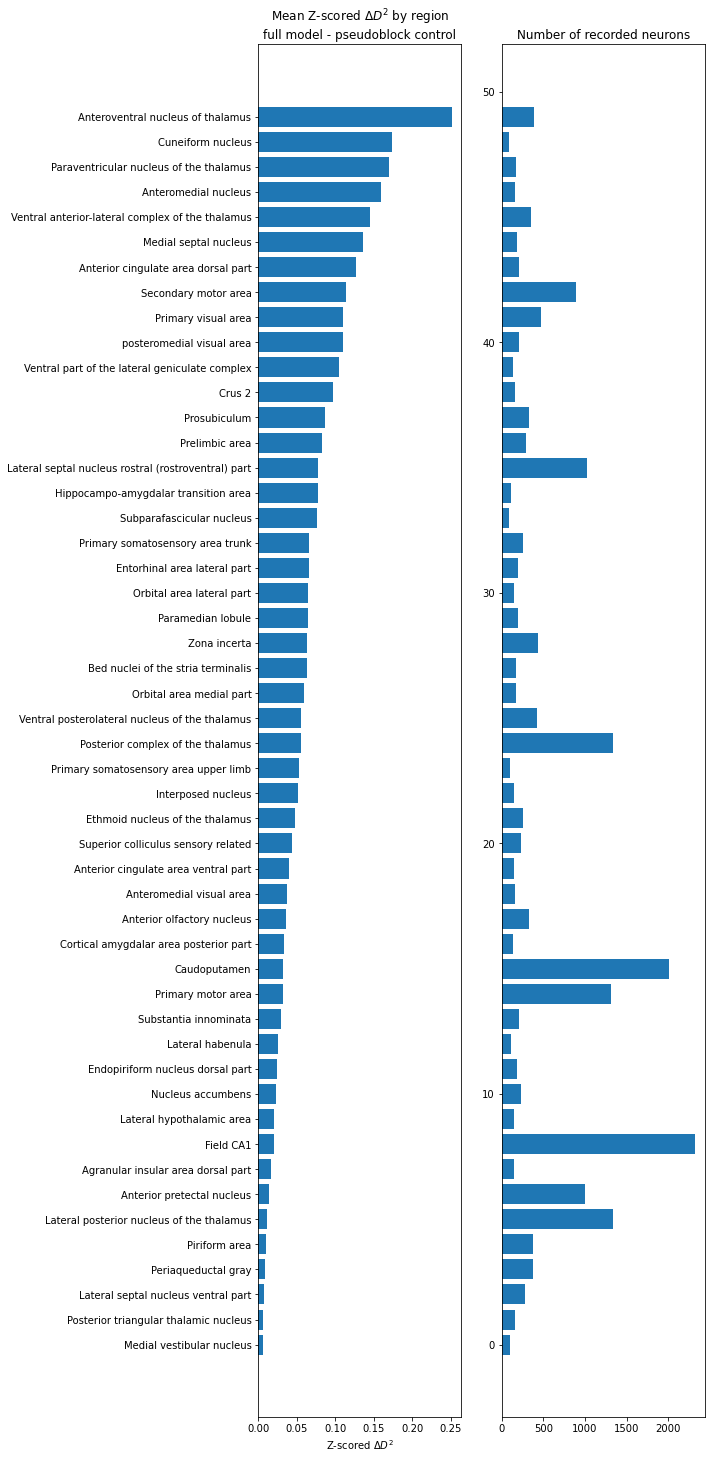

In [340]:
grouper = 'name'

topregions = masterscores[grouper].value_counts()
topregions = topregions[topregions > 80]

topreg_master = masterscores[np.isin(masterscores[grouper], topregions.index)].copy()

n_regions = 50
topreg_melt = deltascores[np.isin(deltascores[grouper], topregions.index)]
fig, ax = plt.subplots(1, 2, figsize=(8, len(topregions) * 0.25))
medians = topreg_melt.groupby(grouper).agg({'diff':'median'}).sort_values('diff', ascending=False)[:n_regions]
means = topreg_melt.groupby(grouper).agg({'diff':'mean'}).sort_values('diff', ascending=False)[:n_regions]
zmeans = topreg_melt.groupby(grouper).agg({'zsc':'mean'}).sort_values('zsc', ascending=False)[:n_regions]
order = zmeans.index
ax[0].barh(range(len(zmeans)), zmeans.values.flatten()[::-1], tick_label=zmeans.index[::-1])
ax[0].set_title('Mean Z-scored $\Delta D^2$ by region\nfull model - pseudoblock control')
ax[0].set_xlabel(r'Z-scored $\Delta D^2$')

ax[1].barh(range(len(zmeans)), masterscores.name.value_counts().reindex(order)[::-1])
ax[1].set_title('Number of recorded neurons')


Text(0.5, 1.0, 'Proportion of cells with full-model score above 95% of pseudoblock scores')

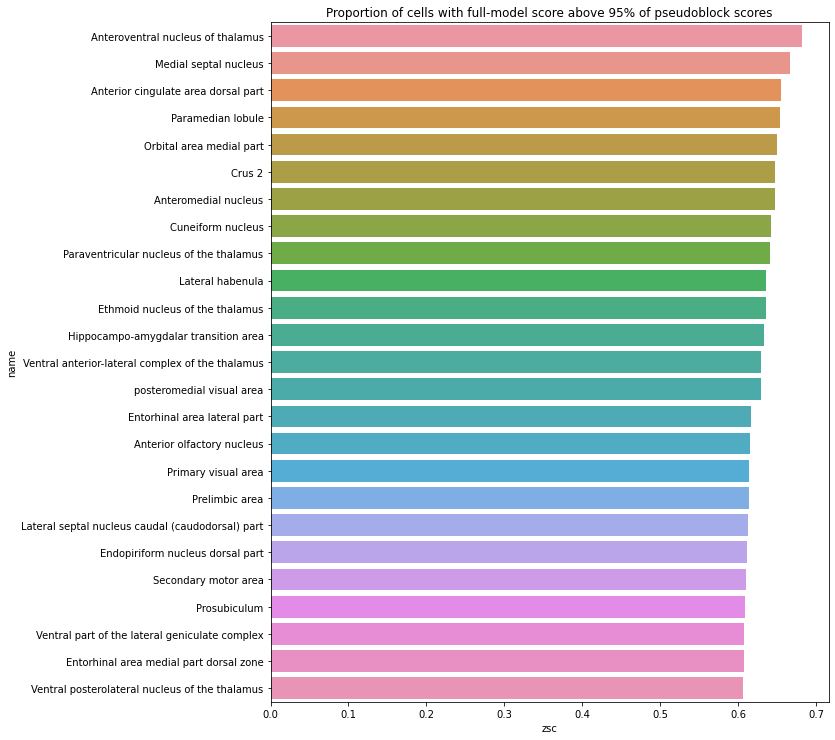

In [339]:
n_regions = 25
grpby = masterscores[np.isin(masterscores[grouper], topregions.index)].groupby(grouper)
sigprops = grpby.agg({'zsc': lambda sr: np.mean(sr > 0)}).sort_values('zsc', ascending=False)[:n_regions]
plt.figure(figsize=(10, n_regions * 0.5))
sns.barplot(x='zsc', y='name', data=sigprops.reset_index(), orient='h')
plt.title('Proportion of cells with full-model score above 95% of pseudoblock scores')

In [17]:
# diffs = short_medians - medians
# topdiffs = diffs.sort_values(by='value', ascending=False)
# topdiffs

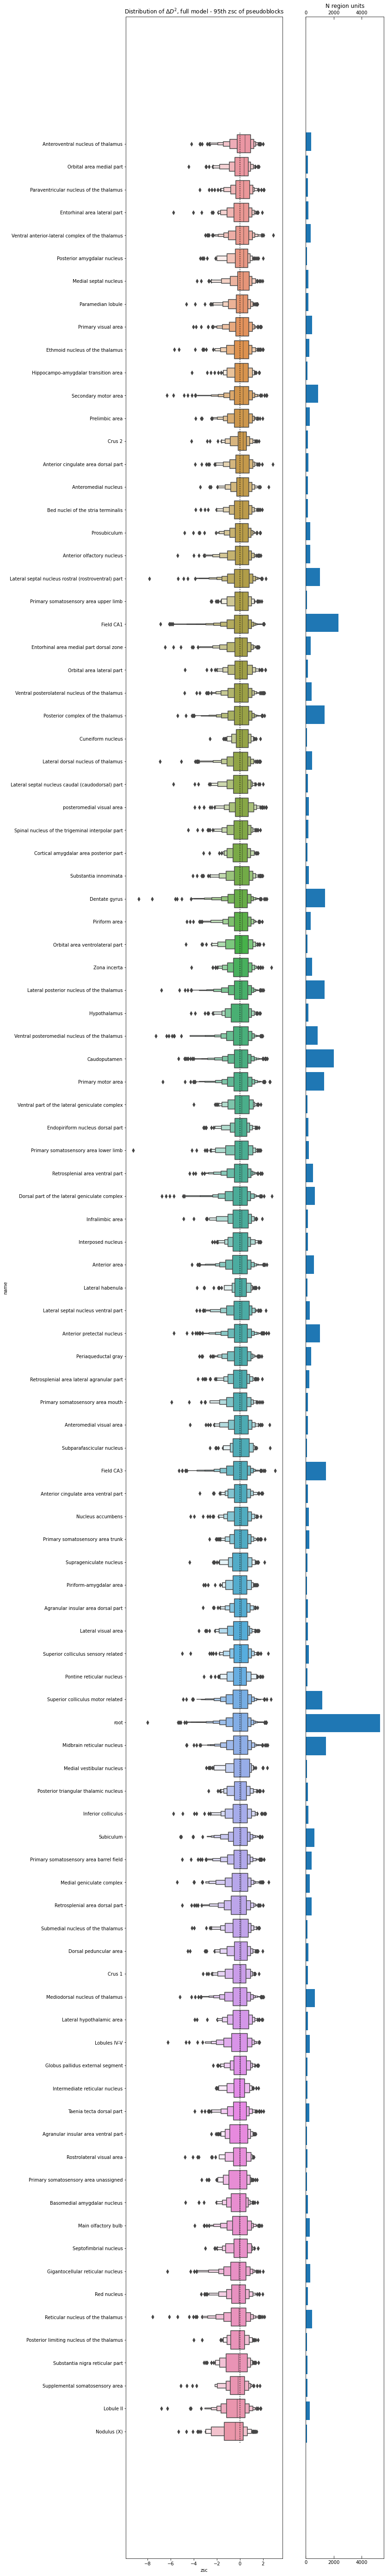

In [341]:
topreg_master = masterscores[np.isin(masterscores[grouper], topregions.index)]
regorder = topreg_master.groupby(grouper).agg({'zsc':'median'}).sort_values('zsc', ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(10, len(topregions)), gridspec_kw={'width_ratios': [2, 1]})
sns.boxenplot(data=topreg_master, x='zsc', y=grouper,
              order=regorder, ax=ax[0])
ax[0].vlines(0, ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='k', ls=':')
ax[0].set_title(r'Distribution of $\Delta D^2$, full model - 95th zsc of pseudoblocks')
# ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=45)

ax[1].barh(ax[0].get_yticks(), topreg_master[grouper].value_counts().loc[regorder].iloc[::-1])
ax[1].set_yticks([])
ax[1].set_title('N region units')
ax[1].tick_params(labeltop=True, top=True, direction='in', length=6)

Text(0.5, 1.0, 'Number of recorded neurons')

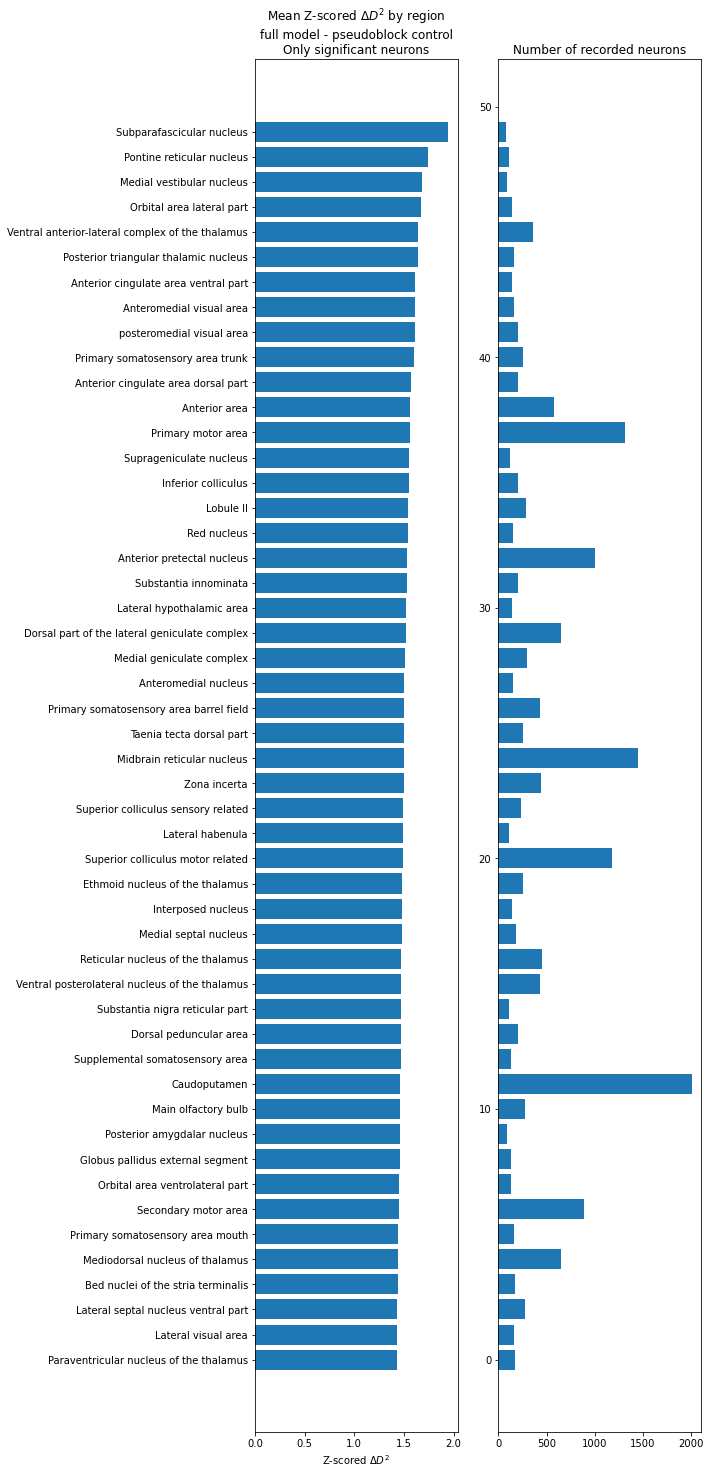

In [343]:
n_regions = 50
topreg = masterscores[np.isin(masterscores[grouper], topregions.index)]
topreg = topreg[topreg['significant']]
fig, ax = plt.subplots(1, 2, figsize=(8, len(topregions) * 0.25))
zmeans = topreg.groupby(grouper).agg({'zsc':'mean'}).sort_values('zsc', ascending=False)[:n_regions]
order = zmeans.index
ax[0].barh(range(len(zmeans)), zmeans.values.flatten()[::-1], tick_label=zmeans.index[::-1])
ax[0].set_title('Mean Z-scored $\Delta D^2$ by region\nfull model - pseudoblock control\nOnly significant neurons')
ax[0].set_xlabel(r'Z-scored $\Delta D^2$')

ax[1].barh(range(len(zmeans)), masterscores.name.value_counts().reindex(order)[::-1])
ax[1].set_title('Number of recorded neurons')

In [144]:
# fw = open(f'/media/berk/Storage1/completefits_{fitdate}.p', 'wb')
# filenames = list(filedata.keys())
# output = {'masterscores': masterscores, 'rawpoints': rawpoints, 'file_names': filenames,
#           'session_uuids': [str(filedata[fn]['sessinfo']['session_uuid']) for fn in filenames]}
# pickle.dump(output, fw)
# fw.close()
interleaved_masterscores = masterscores
interleaved_rawpoints = rawpoints

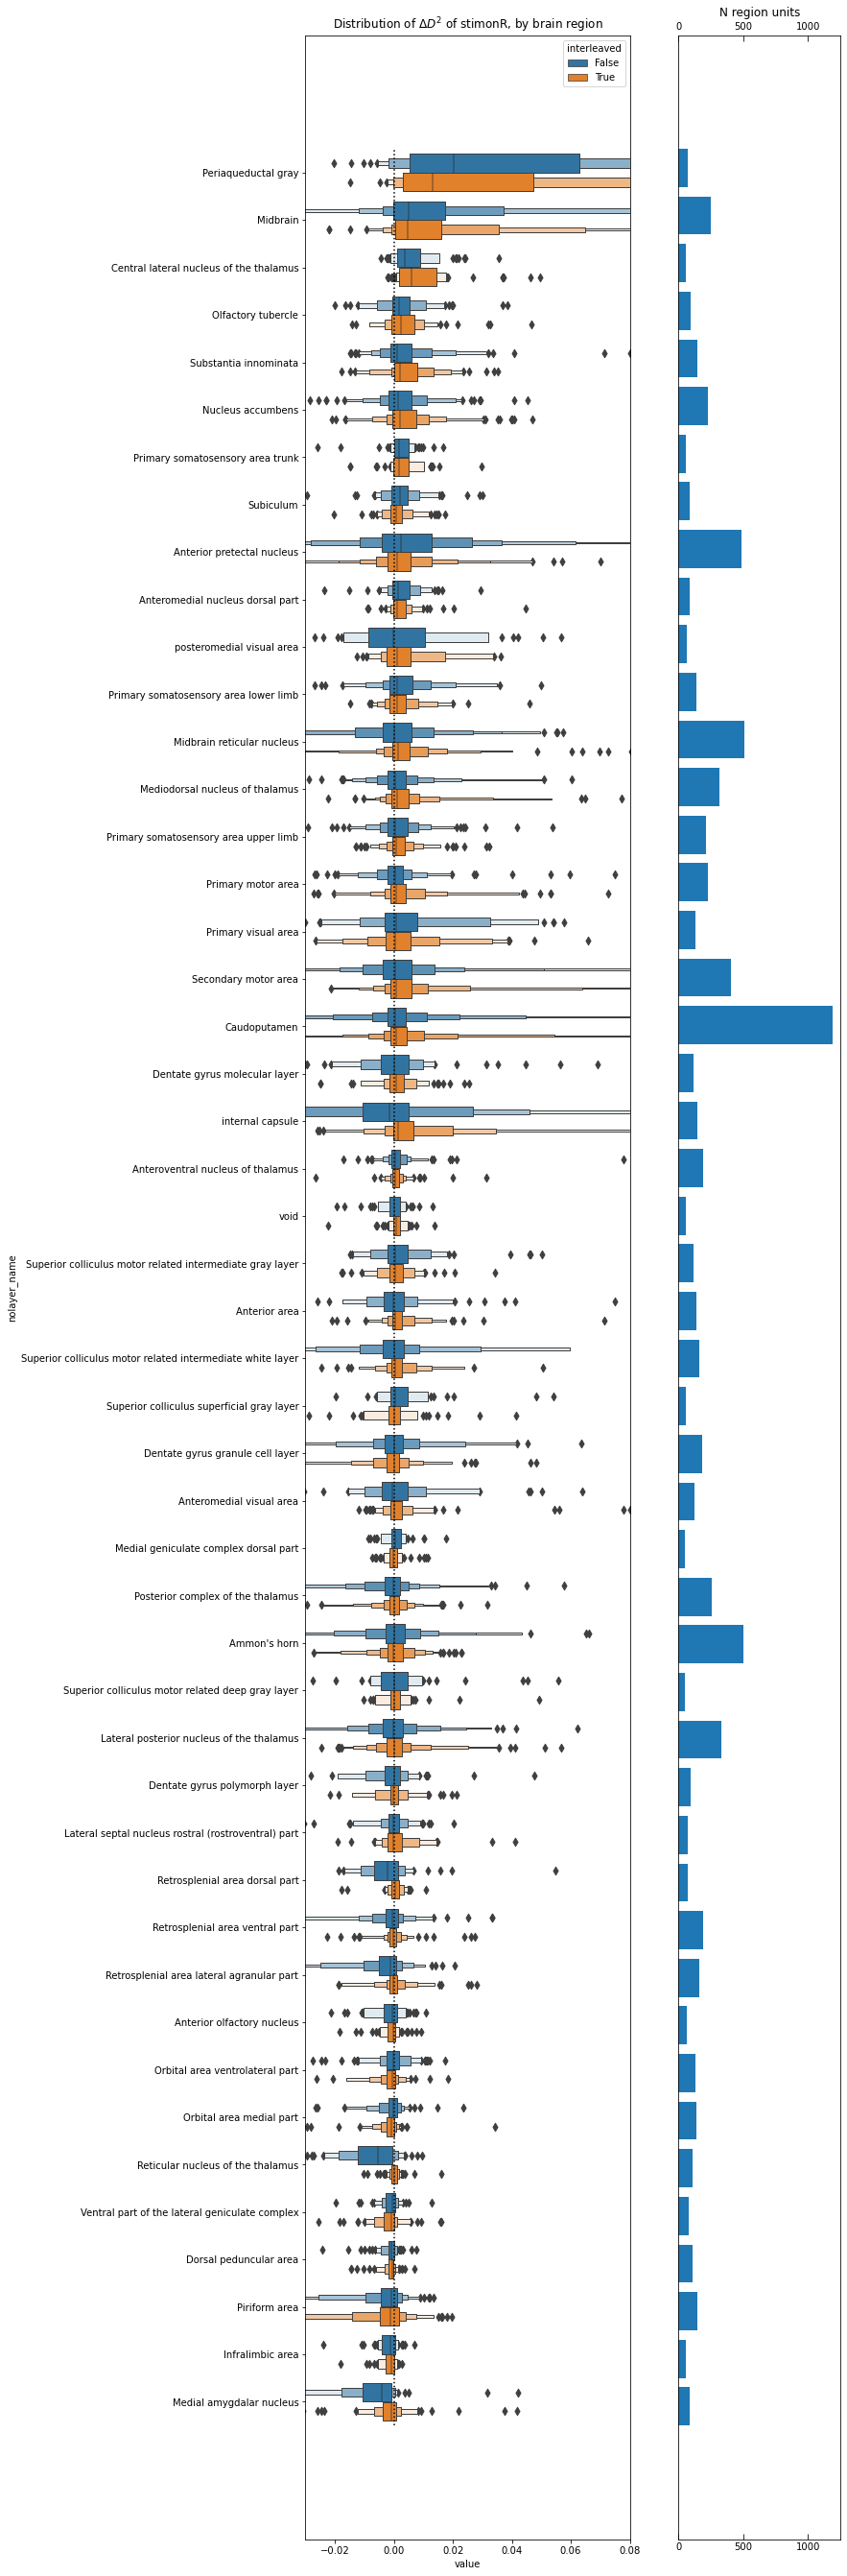

In [79]:
kern_name = 'stimonR'
badinds = topreg_master.index[topreg_master.tag_0 == 'None']
topreg_melt = test[np.isin(test[grouper], topregions.index)].drop(index=badinds)
topreg_melt['group'] = topreg_melt['covname'].apply(lambda st: kern_name if st == kern_name else 'others')
regorder = topreg_melt[topreg_melt.covname == kern_name].groupby(grouper).agg({'value':'median'}).sort_values('value', ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(10, len(topregions)), gridspec_kw={'width_ratios': [2, 1]})
sns.boxenplot(data=topreg_melt[topreg_melt.group == kern_name], x='value', y=grouper,
              hue='interleaved',
              order=regorder, ax=ax[0])
if kern_name == 'correct':
    ax[0].set_xlim([-0.05, 0.50])
else:
    ax[0].set_xlim([-0.03, 0.08])
ax[0].vlines(0, ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='k', ls=':')
ax[0].set_title(r'Distribution of $\Delta D^2$' + f' of {kern_name}, by brain region')
# ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=45)

ax[1].barh(ax[0].get_yticks(), topreg_master[grouper].value_counts().loc[regorder].iloc[::-1])
ax[1].set_yticks([])
ax[1].set_title('N region units')
ax[1].tick_params(labeltop=True, top=True, direction='in', length=6)

(-0.05, 0.09)

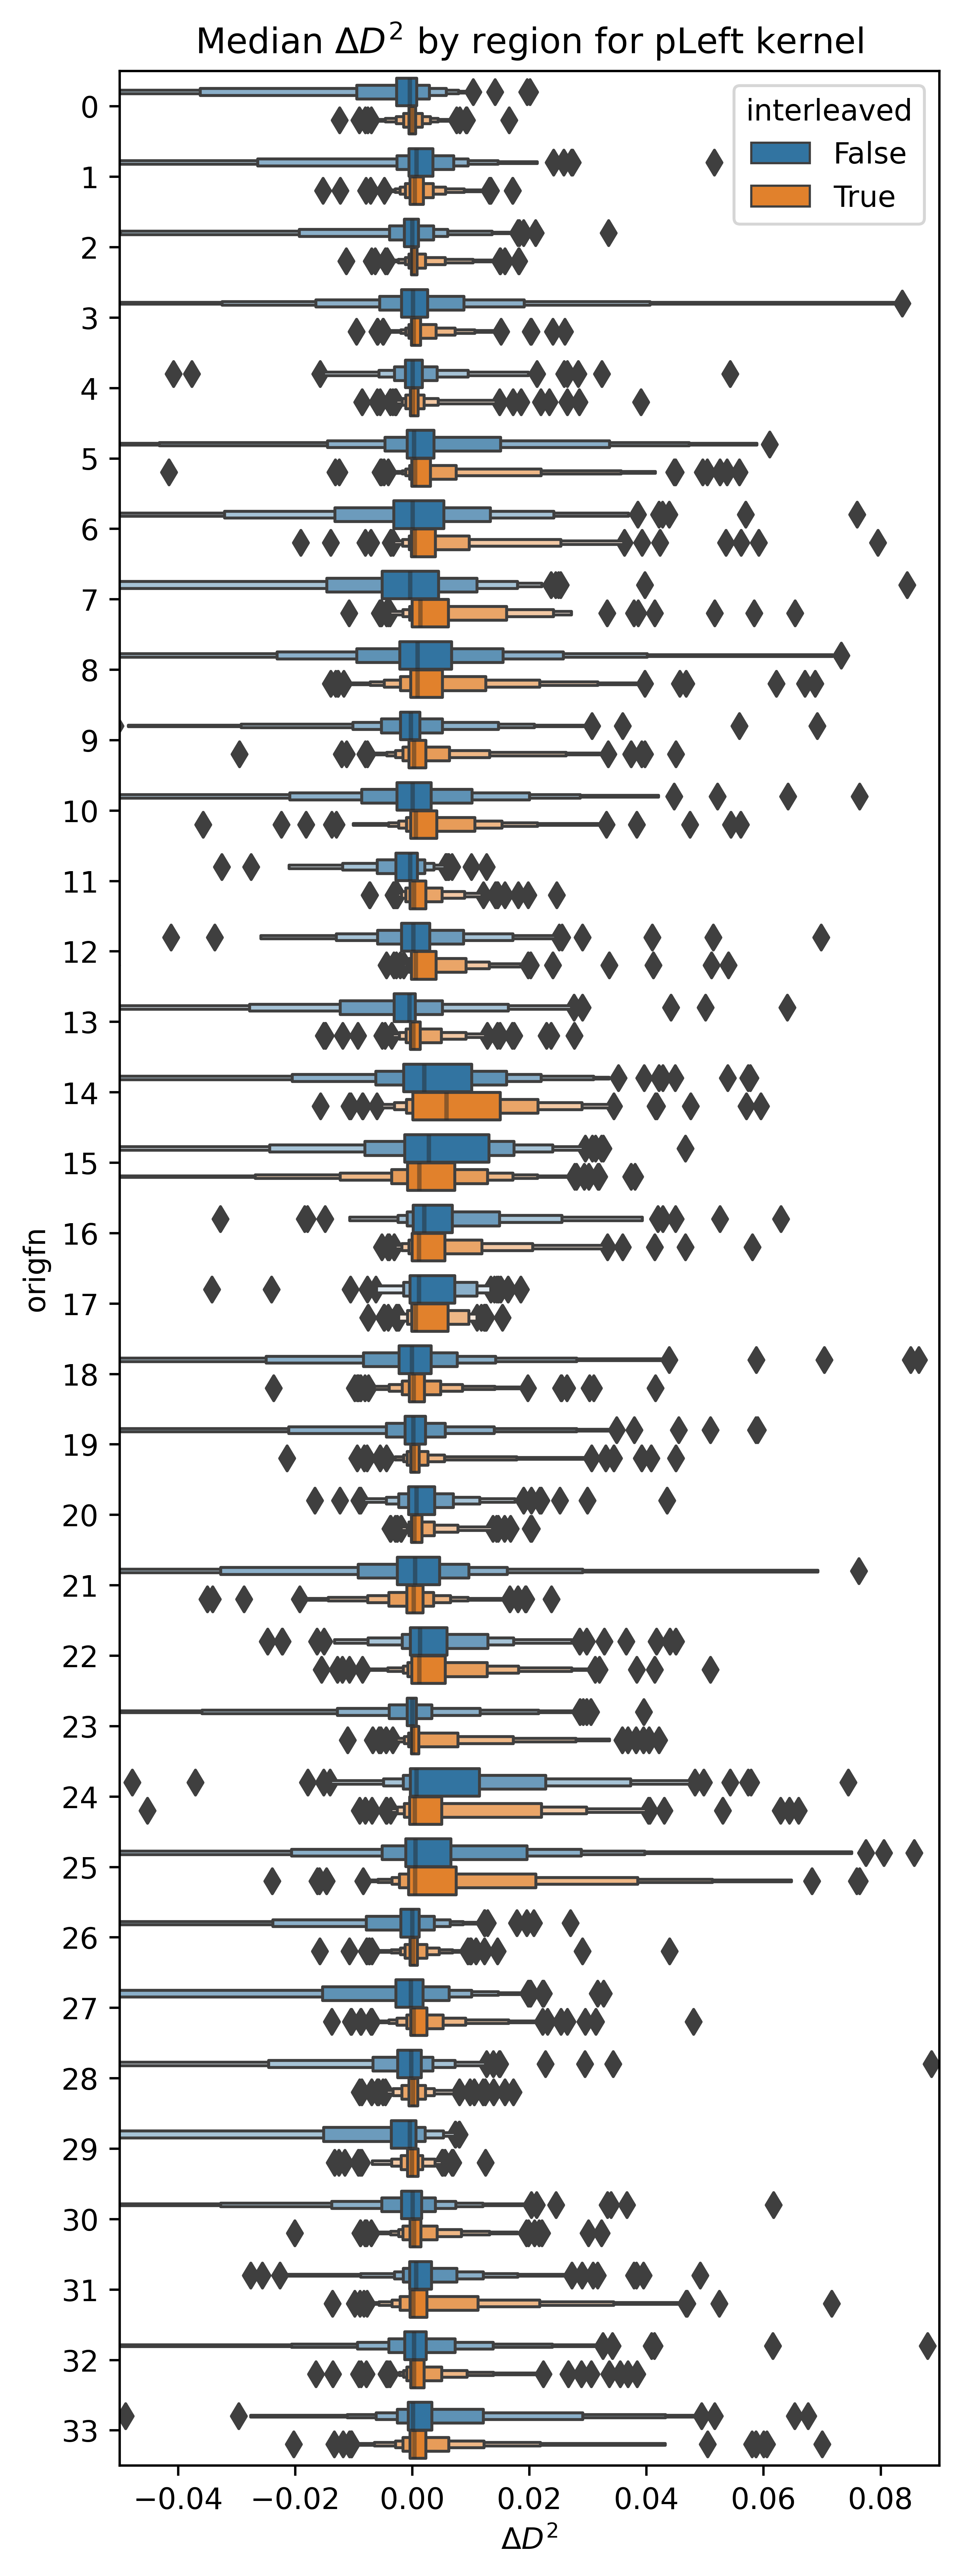

In [198]:
n_regions = 30
kern_name = 'pLeft'
grouper = 'origfn'
badinds = topreg_master.index[topreg_master.tag_0 == 'None']
# topreg_melt = test[np.isin(test[grouper], topregions.index)]  # .drop(index=badinds)
topreg_melt = test
fig, ax = plt.subplots(1, 1, figsize=(5, n_regions * 0.5), dpi=600)
covmelt = topreg_melt[(topreg_melt.covname == kern_name) & (topreg_melt.value > -1) & (topreg_melt.value < 1)]
medians = covmelt[~covmelt.interleaved].groupby(grouper).agg({'value':'median'}).sort_values('value', ascending=False)[:n_regions]
sns.boxenplot(data=covmelt, x='value', y='origfn', hue='interleaved', orient='h')
ax.set_title(r'Median $\Delta D^2$ by region for' + f' {kern_name} kernel')
ax.set_xlabel(r'$\Delta D^2$')
ax.set_xlim([-.05, 0.09])
# plt.legend(loc=4, prop={'size':18})

Text(0.5, 1.0, 'Distribution of model improvement $\\Delta D^2$ for primary visual area')

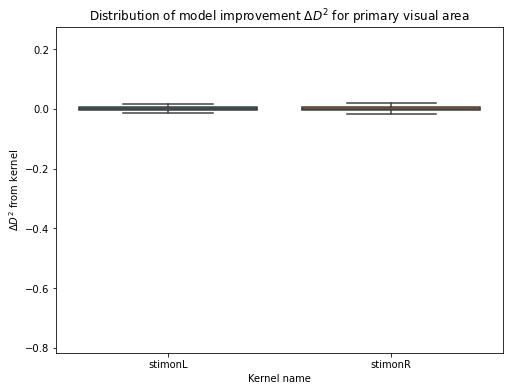

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.boxplot(data=topreg_melt[topreg_melt.nolayer_name == 'Primary visual area'],
            x='covname', y='value', order=['stimonL', 'stimonR'], ax=ax, fliersize=0)
ax.set_ylabel('$\Delta D^2$' + ' from kernel')
ax.set_xlabel('Kernel name')
ax.set_title('Distribution of model improvement $\Delta D^2$ for primary visual area')
# ax.set_ylim([-0.05, 0.15])

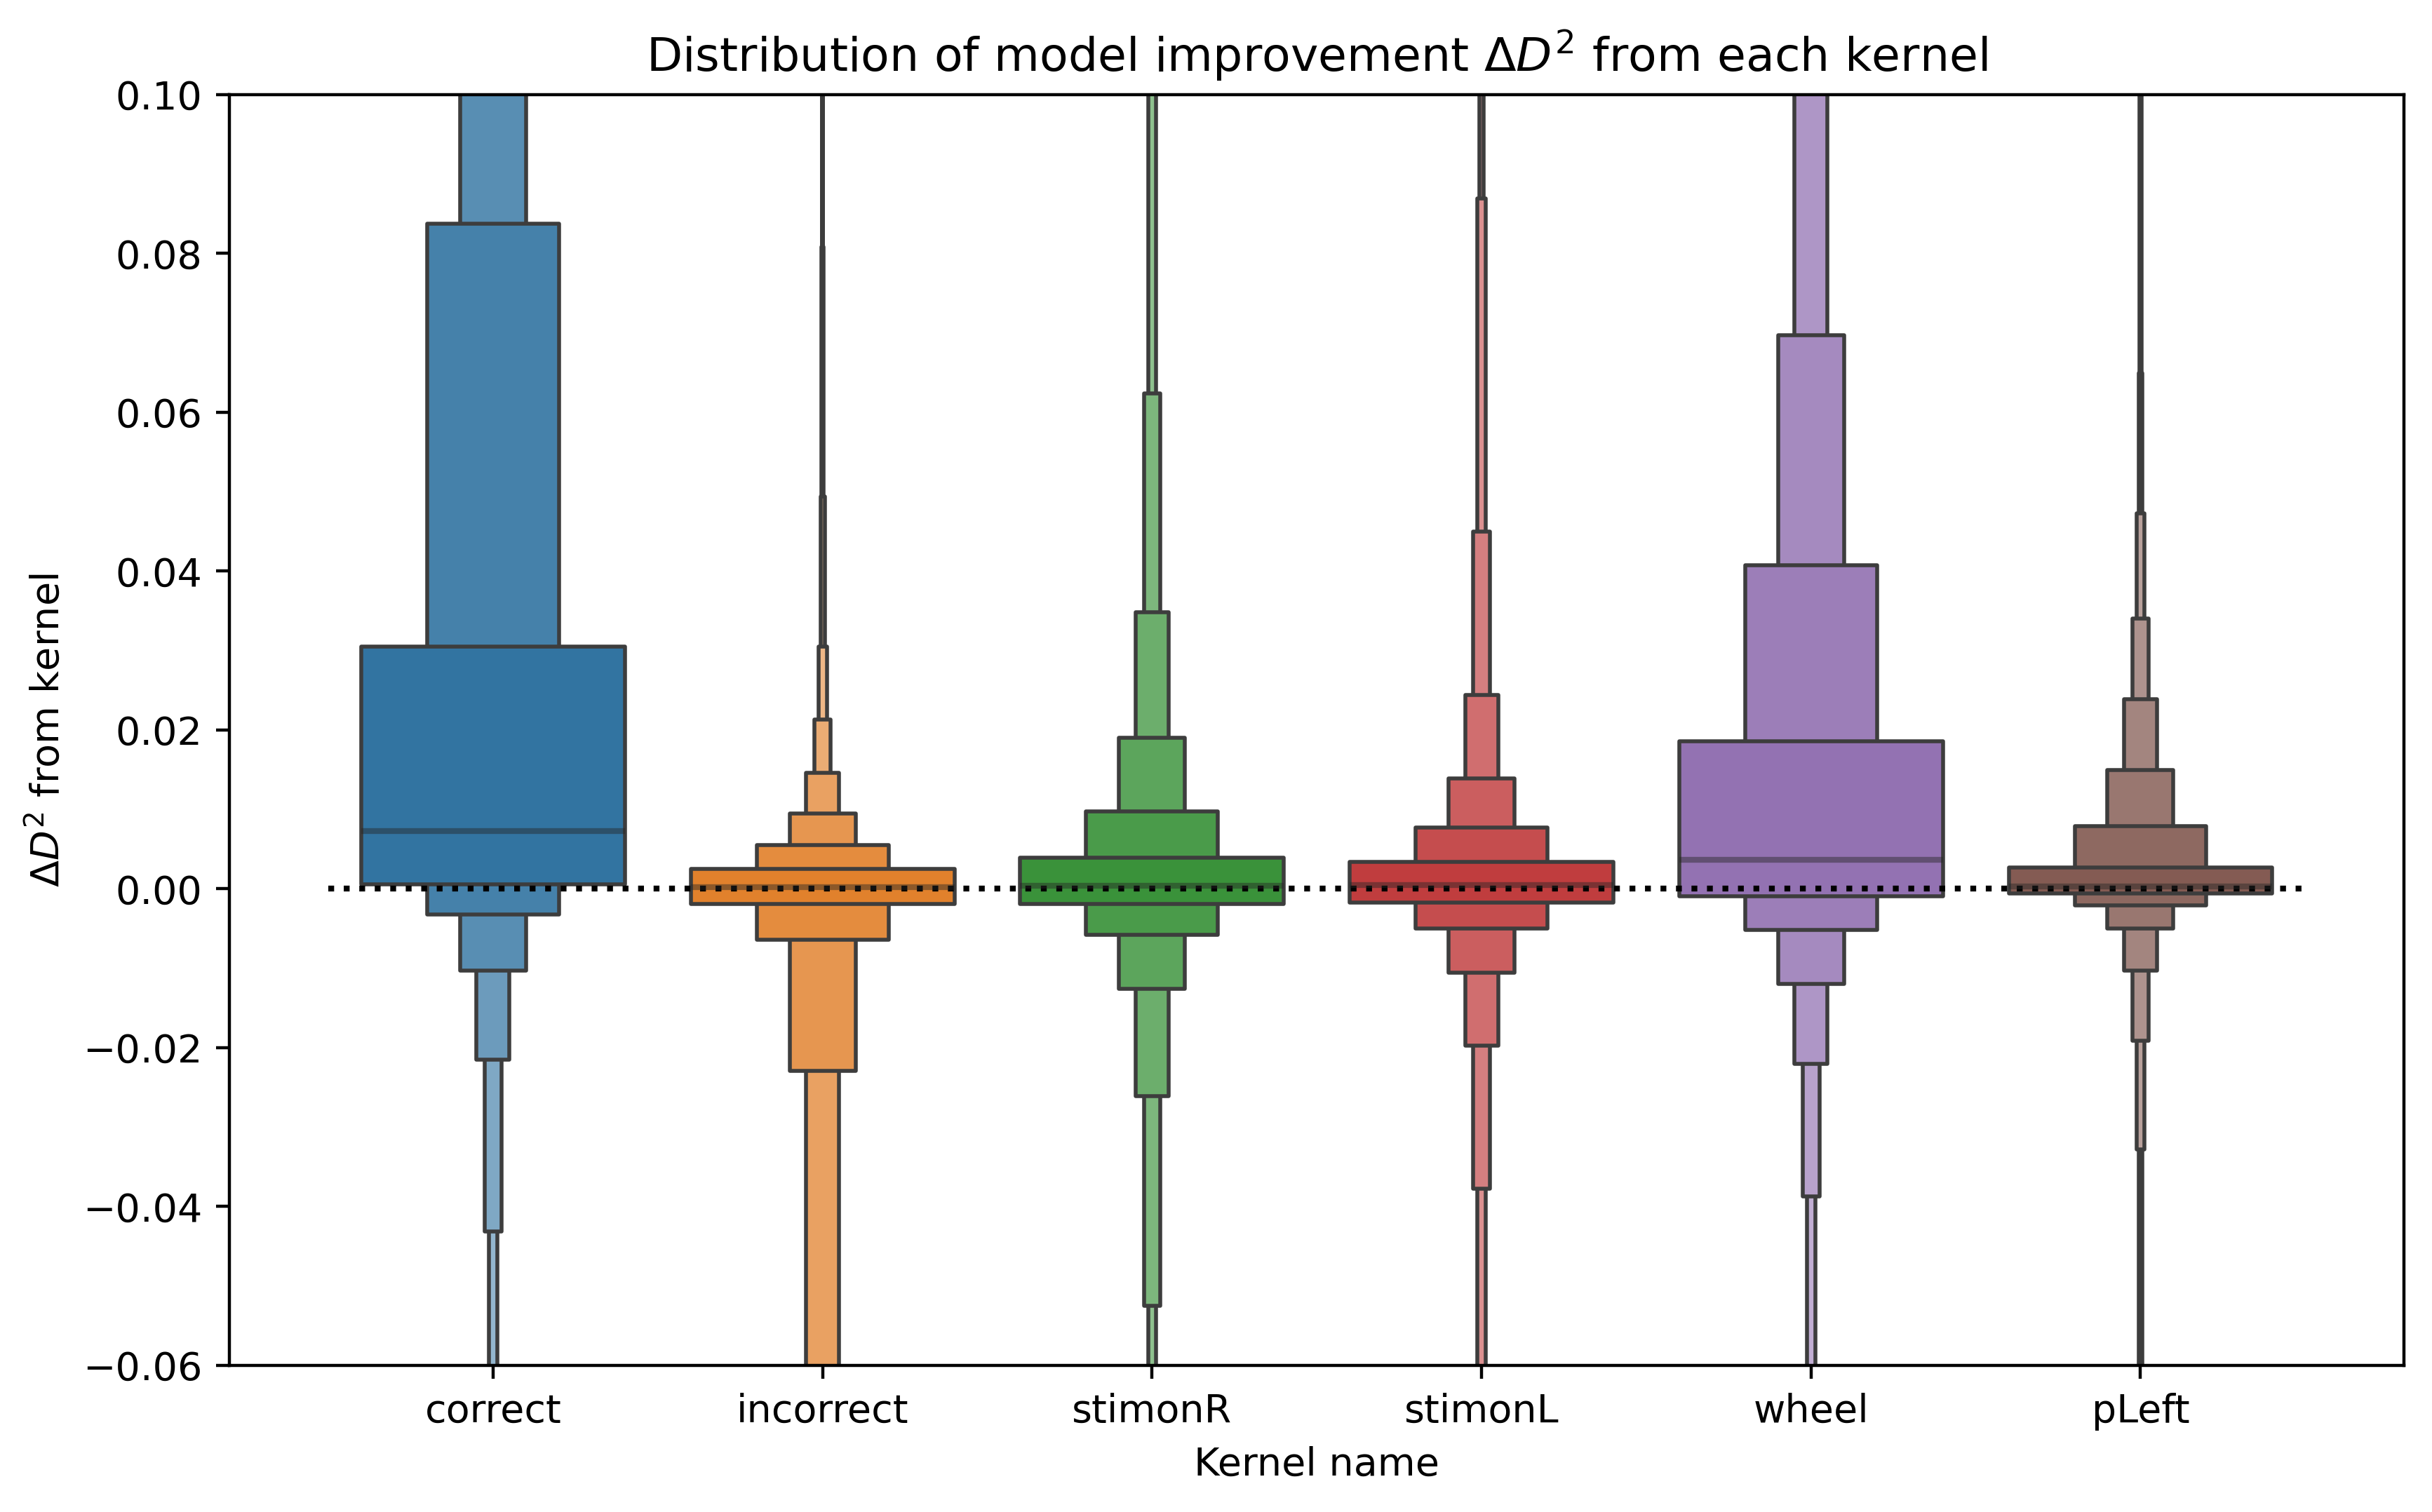

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=400)
sns.boxenplot(data=topreg_melt, x='covname', y='value',
            order=['correct', 'incorrect', 'stimonR', 'stimonL', 'wheel', 'pLeft'], # fliersize=0,
            ax=ax,
            # cut=0, inner='quartiles',
            )
ax.set_ylabel('$\Delta D^2$' + ' from kernel')
ax.set_xlabel('Kernel name')
ax.set_title('Distribution of model improvement $\Delta D^2$ from each kernel')
ax.set_ylim([-0.06, 0.1])
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='k', ls=':')

In [73]:
masterscores[masterscores.nolayer_name == 'Anterior cingulate area dorsal part'].origfn.value_counts()

36    65
1     46
Name: origfn, dtype: int64

In [91]:
import ipywidgets as ipw
import brainbox.atlas as bbat

def drop_subzero_max(row):
    maxind = row.tag_0
    if row[maxind] < 0:
        row.tag_0 = 'None'
    return row

masterscores_drop = masterscores.apply(drop_subzero_max, axis=1)

badinds = masterscores_drop.index[masterscores_drop.tag_0 == 'None']
dropzero_melt = rawpoints.drop(index=badinds)

topregions = masterscores['nolayer_acr'].value_counts()
topregions = topregions[topregions > 50]

medians = dropzero_melt[np.isin(dropzero_melt.nolayer_acr, topregions.index)].groupby(['nolayer_acr', 'covname']).agg({'value': 'mean'})
# medians = rawpoints.groupby(['nolayer_acr', 'covname']).agg({'value': 'mean'})
# models = ['1cov_diff', '2cov_diff', '3cov_diff']
kernels = ['correct', 'incorrect', 'pLeft', 'stimonR', 'stimonL', 'wheel']

mlslider = ipw.FloatSlider(min=-5, max=5, step=0.01, value=-0.5, description='Medial-Lateral axis (mm)')
apslider = ipw.FloatSlider(min=-5, max=5, step=0.01, value=-1., description='Anterior-Posterior axis (mm)')
dvslider = ipw.FloatSlider(min=-4, max=8, step=0.01, value=7, description='Dorsal-Ventral axis (mm)')
@ipw.interact_manual
def delta_dsq_heatmap(kernel=kernels, ML=mlslider, AP=apslider, DV=dvslider):
    data = medians.loc[:, kernel, :]
#     data = data.copy()[np.abs(data) < 0.06]
    regions = data.index.to_numpy().reshape(-1)
#     print(data)
    values = data.values.reshape(-1)
#     regions = regions[np.abs(values) < 0.008]
#     values = values[np.abs(values) < 0.008]
    fig, axes = plt.subplots(1, 3, figsize=(25, 5),
#                              gridspec_kw={'width_ratios': [1.5, 1, 1]},
                             dpi=400)
    bbat.plot_atlas(regions, values, ML, AP, DV, axs=axes, custom_region_list=all_regions, color_palette='Reds')
    plt.suptitle(f'Additional {kernel} contribution')
    return

interactive(children=(Dropdown(description='kernel', options=('correct', 'incorrect', 'pLeft', 'stimonR', 'sti…

In [87]:
from brainbox.io.one import load_spike_sorting_with_channel
from export_funs import trialinfo_to_df

target_kernel = 'pLeft'
top_regions = medians.loc[:, target_kernel, :].sort_values('value', ascending=False).index[:3]
top_fns = [list(filenames)[rawpoints[rawpoints.nolayer_acr == reg]['origfn'].value_counts().index[0]] for reg in top_regions]

data = {}
for fn, region in zip(top_fns, top_regions):
    data[region] = {}
    
    uuid = str(filedata[fn]['sessinfo']['session_uuid'])
    spikes, clusters, _ = load_spike_sorting_with_channel(uuid)
    data[region]['uuid'] = uuid
    data[region]['filename'] = fn
    probestr = 'probe0' + str(filedata[fn]['sessinfo']['probe_idx'])
    data[region]['spike_times'] = spikes[probestr].times
    data[region]['spike_clusters'] = spikes[probestr].clusters
    data[region]['brain_region'] = clusters[probestr].acronym
    data[region]['trialsdf'] = trialinfo_to_df(uuid, maxlen=2., ret_wheel=True)

2020-11-24 13:18:49.440 INFO     [one.py:266] Local files for spikes and clusters for /media/berk/Storage1/flatiron/zadorlab/Subjects/CSH_ZAD_022/2020-05-26/001 and probe00 found. To re-download set force=True


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-11-24 13:18:49.582 INFO     [one.py:125] Channel locations for probe00 have not been resolved. Channel and cluster locations obtained from histology track.
2020-11-24 13:18:54.541 INFO     [one.py:266] Local files for spikes and clusters for /media/berk/Storage1/flatiron/zadorlab/Subjects/CSH_ZAD_022/2020-05-27/001 and probe00 found. To re-download set force=True


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-11-24 13:18:54.680 INFO     [one.py:125] Channel locations for probe00 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-11-24 13:19:00.154 INFO     [one.py:266] Local files for spikes and clusters for /media/berk/Storage1/flatiron/churchlandlab/Subjects/CSHL053/2020-02-03/003 and probe01 found. To re-download set force=True
2020-11-24 13:19:00.292 INFO     [one.py:125] Channel locations for probe01 have not been resolved. Channel and cluster locations obtained from histology track.


In [89]:
from brainbox.plot import peri_event_time_histogram

region = top_regions[0]
region_clusters = np.isin(data[region]['spike_clusters'], np.argwhere(data[region]['brain_region'] == region))
spk_t = data[region]['spike_times'][region_clusters]
spk_clu = data[region]['spike_clusters'][region_clusters]
region_unit_ids = np.unique(spk_clu)
origfn = list(filenames).index(fn)
bestunits = rawpoints[(rawpoints.origfn == origfn) & (rawpoints.nolayer_acr == region) & (rawpoints.covname == 'pLeft')].value.idxmax()

@interact
def plot_unit_psth(unit=region_unit_ids):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    trialsdf = data[region]['trialsdf']
    trialsdf_low = trialsdf[trialsdf.probabilityLeft == 0.2].stimOn_times - 0.35
    trialsdf_high = trialsdf[trialsdf.probabilityLeft == 0.8].stimOn_times - 0.35
    peri_event_time_histogram(spk_t, spk_clu, trialsdf_low, unit, t_before=0.25, t_after=0.25, error_bars='sem',
                              pethline_kwargs={'color': 'red', 'lw': 2, 'label': 'P(Left) low'},
                              errbar_kwargs={'color': 'red', 'alpha': 0.5},
                              include_raster=True, n_rasters=60, ax=ax[0])
    ax[0].set_title('P(Left) = 0.2')
    peri_event_time_histogram(spk_t, spk_clu, trialsdf_high, unit, t_before=0.25, t_after=0.25, error_bars='sem',
                              pethline_kwargs={'color': 'blue', 'lw': 2, 'label': 'P(Left) high'},
                              errbar_kwargs={'color': 'red', 'alpha': 0.5},
                              include_raster=True, n_rasters=60, ax=ax[1])    
    ax[1].set_title('P(Left) = 0.8')

ValueError: attempt to get argmax of an empty sequence

In [90]:
origfn

18

In [96]:
trialsdf = data['Anterior cingulate area dorsal part']['trialsdf'].probabilityLeft
test = np.argwhere(np.diff(data['Anterior cingulate area dorsal part']['trialsdf'].probabilityLeft))
test2 = test[1:] - test[:-1]

7
